# VR Assignment 2

*Subhajeet Lahiri - IMT2021022* \
*Sai Madhavan G - IMT2021101* \
*Aditya Garg - IMT2021545*

## Part B

This part of the assignment involves a **category recognition task**, with the objective being classification between bikes and horses. The classification is to be implemented using a visual bag of words approach. In this approach, first the interest points and their descriptors have to be extracted. Then clustering has to be performed on these "features" in order to get parts or visual words. Each of the images can now be characterised by the number of times each part occurs in the form of a histogram. Finally a classifier can be trained on these images where the histogram values could be used as the features.

## The dataset

The dataset provided for this task contains 99 images of horses and 80 images of bikes. The images are very diverse in terms of intra-class variants, postures, lightings, occlusions, image quality etc.

## Code

In [94]:
# Importing necessary libraries

import cv2 as cv
import os
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import torch

### Extracting and clustering features

For extracting and clustering features from the entire corpus, we define a `FeatureBag` class, which can iterates over all the images in the given folder, identify the keypoints using the SIFT implementation of OpenCV, cluster these features using KMeans implementation of scikit-learn and then return the feature histogram for any image.

In [46]:
class FeatureBag:
    def __init__(self, directory, seed = 42):
        self.seed = seed
        self.features = []
        for f in tqdm(os.listdir(directory), "Extracting features from images: "):
            img = cv.imread(os.path.join(directory, f))
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            
            sift = cv.SIFT_create()
            keypoints, descriptors = sift.detectAndCompute(gray, None)
            self.features.extend(descriptors)
        print(f"Total number of features: {len(self.features)}")
        
    def cluster(self, k, verbose=True):
        self.k = k
        self.kmeans = KMeans(
            n_clusters = self.k,
            random_state = self.seed,
        ).fit(self.features)
        if verbose:
            print(f"Clustering with {self.k} clusters complete")

    def elbowCurve(self, ks):
        ks = sorted(ks)
        inertias = []
        for k in tqdm(ks, "Clustering with different values of k"):
            self.cluster(k, verbose=False)
            inertias.append(self.kmeans.inertia_)
        plt.plot(ks, inertias, marker='x')
        plt.title('Elbow Method for Optimal Clusters')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Inertia')
        plt.show()
        
    def assignLabel(self, image):
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        sift = cv.SIFT_create()
        k, descriptors  = sift.detectAndCompute(gray, None)
        histogram = [0]*self.k
        for descriptor in descriptors:
            label = self.kmeans.predict(descriptor.reshape(1, -1).astype('double'))
            histogram[label[0]] += 1
        return histogram

In [47]:
featureBag = FeatureBag('./featurebag')
featureBag.cluster(20)

Extracting features from images:   0%|          | 0/179 [00:00<?, ?it/s]

Total number of features: 169455
Clustering with 20 clusters complete


#### Determining the number of clusters

There seems to be close to 169k features in all the 179 images combined. To determine the ideal number of clusters, we apply the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) by plotting the intertia obtained for each `k` used.

Clustering with different values of k: 100%|██████████| 20/20 [04:11<00:00, 12.56s/it]


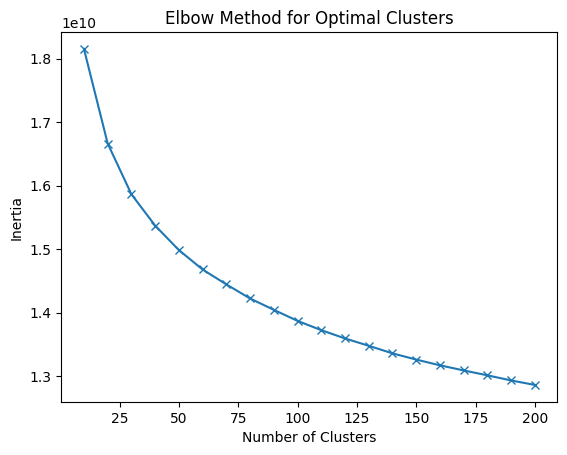

In [22]:
featureBag.elbowCurve(range(10, 201, 10))

Although there is not a very sharp elbow, **70** seems to be a good number of features. 

In [48]:
featureBag.cluster(70)

Clustering with 70 clusters complete


### Creating a dataset

Now that we have a way to characterize each image, we define a `Dataset` class to handle all the utilities in creating a dataset of the desired format.

In [73]:
class Dataset:
    def __init__(self, source_dir, classes, featureBag, seed=42):
        self.source_dir = source_dir
        self.classes = classes
        self.featureBag = featureBag
        self.seed = seed
        self.extractPaths()
        self.createHistograms()
        self.trainTestSplit()

    def extractPaths(self):
        self.images = []
        for class_ in self.classes:
            image_paths = os.listdir(os.path.join(self.source_dir, class_))
            class_images = [cv.imread(os.path.join(self.source_dir, class_, image_path)) for image_path in image_paths]
            self.images.append(class_images)
        
    def createHistograms(self):
        self.histograms = []
        for class_idx, class_ in enumerate(self.classes):
            class_histograms = []
            for image in self.images[class_idx]:
                histogram = self.featureBag.assignLabel(image)
                class_histograms.append(histogram)
            self.histograms.append(np.array(class_histograms))

    def trainTestSplit(self):
        X = np.concatenate(self.histograms)
        y = []
        for label_idx, label in enumerate(self.classes):
            y.extend([label_idx]*self.histograms[label_idx].shape[0])
        self.X_train, self.X_test, self.y_train, self.y_test =  train_test_split(X, y, test_size=0.2, stratify=y, random_state=self.seed)

In [74]:
dataset = Dataset('.\\dataset', ['Bikes', 'Horses'], featureBag)

In [80]:
dataset.X_train.shape, dataset.X_test.shape

((143, 70), (36, 70))

### Training models

Now that we have data in our desired format, we can train various models and compare their performances.

#### SVM

In [83]:
svm_clf = svm.SVC()
svm_clf.fit(dataset.X_train, dataset.y_train)

svm_preds = svm_clf.predict(dataset.X_test)

print(classification_report(dataset.y_test, svm_preds))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.90      0.95      0.93        20

    accuracy                           0.92        36
   macro avg       0.92      0.91      0.92        36
weighted avg       0.92      0.92      0.92        36



#### Logistic Regression

In [86]:
lg_clf = LogisticRegression()
lg_clf.fit(dataset.X_train, dataset.y_train)

lg_preds = lg_clf.predict(dataset.X_test)

print(classification_report(dataset.y_test, lg_preds))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.90      0.95      0.93        20

    accuracy                           0.92        36
   macro avg       0.92      0.91      0.92        36
weighted avg       0.92      0.92      0.92        36



c:\programming\projects\pj_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### KNN

In [88]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(dataset.X_train, dataset.y_train)

knn_preds = knn_clf.predict(dataset.X_test)

print(classification_report(dataset.y_test, knn_preds))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.90      0.90      0.90        20

    accuracy                           0.89        36
   macro avg       0.89      0.89      0.89        36
weighted avg       0.89      0.89      0.89        36



#### Gaussian Naive Bayes

In [90]:
gnb_clf = GaussianNB()
gnb_clf.fit(dataset.X_train, dataset.y_train)

gnb_preds = gnb_clf.predict(dataset.X_test)

print(classification_report(dataset.y_test, gnb_preds))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73        16
           1       1.00      0.40      0.57        20

    accuracy                           0.67        36
   macro avg       0.79      0.70      0.65        36
weighted avg       0.81      0.67      0.64        36



#### Random Forest

In [91]:
rf_clf = RandomForestClassifier()
rf_clf.fit(dataset.X_train, dataset.y_train)

rf_preds = rf_clf.predict(dataset.X_test)

print(classification_report(dataset.y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       1.00      0.85      0.92        20

    accuracy                           0.92        36
   macro avg       0.92      0.93      0.92        36
weighted avg       0.93      0.92      0.92        36



#### Gradient Boosting

In [92]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(dataset.X_train, dataset.y_train)

gb_preds = gb_clf.predict(dataset.X_test)

print(classification_report(dataset.y_test, gb_preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.95      0.97        20

    accuracy                           0.97        36
   macro avg       0.97      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



#### XGBoost

In [96]:
xgb_clf = XGBClassifier()
xgb_clf.fit(dataset.X_train, dataset.y_train)

xgb_preds = xgb_clf.predict(dataset.X_test)

print(classification_report(dataset.y_test, xgb_preds))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.95      0.95      0.95        20

    accuracy                           0.94        36
   macro avg       0.94      0.94      0.94        36
weighted avg       0.94      0.94      0.94        36



#### LightGBM

In [100]:
lgbm_clf = LGBMClassifier()
lgbm_clf.fit(dataset.X_train, dataset.y_train)

lgbm_preds = lgbm_clf.predict(dataset.X_test)

print(classification_report(dataset.y_test, lgbm_preds))

[LightGBM] [Info] Number of positive: 79, number of negative: 64
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1773
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552448 -> initscore=0.210565
[LightGBM] [Info] Start training from score 0.210565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

#### CatBoost

In [102]:
cat_clf = CatBoostClassifier(verbose=False)
cat_clf.fit(dataset.X_train, dataset.y_train)

cat_preds = cat_clf.predict(dataset.X_test)

print(classification_report(dataset.y_test, cat_preds))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        16
           1       1.00      0.90      0.95        20

    accuracy                           0.94        36
   macro avg       0.94      0.95      0.94        36
weighted avg       0.95      0.94      0.94        36



#### MLP Classifier

In [103]:
mlp_clf = MLPClassifier()
mlp_clf.fit(dataset.X_train, dataset.y_train)

mlp_preds = mlp_clf.predict(dataset.X_test)

print(classification_report(dataset.y_test, mlp_preds))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.90      0.95      0.93        20

    accuracy                           0.92        36
   macro avg       0.92      0.91      0.92        36
weighted avg       0.92      0.92      0.92        36



We see that we get the best performance while using gradient boosting and LightBGM, getting 97% accuraccy and 97 f1 score